In [3]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import os
import joblib
from pathlib import Path
from tempfile import TemporaryDirectory
from loguru import logger

import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error

from predictability.models import ResidueAgnosticRegressor, PartialLeastSquares, RITARegressor, PottsRegressor
from predictability.utils import update_environment_variables, assign_ssm_folds, read_fasta
from predictability.sm_utils import get_rita_embeddings, get_potts_emissions
from predictability.constants import DATA_ROOT, PROJECT_ROOT, BINARY_RESIDUE_FEATURES

In [4]:
update_environment_variables("zsh")
DEFAULT_BUCKET = os.environ.get("AWS_DEFAULT_BUCKET")
GLOBAL_DATA_ROOT = os.environ.get("DATA_ROOT")
SEED = 1337
ds = "amylase"
target = "activity_dp3"
n_folds = 10
model_names = ["Residue agnostic regressor", "Partial least squares", "Augmented Potts", "RITA regressor"]
lambda_reg = 0.1
results_dir = PROJECT_ROOT / f"results/singles/{ds}"
results_dir.mkdir(exist_ok=True, parents=True)
reference = [sequence for _, sequence in read_fasta(DATA_ROOT / "amylase/reference.fasta").items()][0]

In [5]:
rita_training_job_names = {
    "amylase": "huggingface-regressor-01-08-09-00"
}
potts_training_job_names = {
    "amylase": "potts-regressor-12-09-53-35"
}

In [6]:
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "structural_characteristic": [],
    "is_member": [],
    "spearman": [],
    "mae": [],
}

data = pd.read_csv(DATA_ROOT / f"amylase/singles.csv").reset_index()
data["embedding_index"] = list(range(len(data)))
embedding_indices = data["embedding_index"].values
data = data.dropna(subset=target)

with TemporaryDirectory() as temp_dir:
    potts_path = get_potts_emissions(
        path=temp_dir,
        dataset=ds,
        training_job_names=potts_training_job_names,
        default_bucket=DEFAULT_BUCKET
    )
    embeddings_path = get_rita_embeddings(
        path=temp_dir,
        dataset=ds,
        training_job_names=rita_training_job_names,
        default_bucket=DEFAULT_BUCKET
    )
    embeddings = np.load(embeddings_path)
    models = [
        ResidueAgnosticRegressor(wildtype_sequence=reference),
        PartialLeastSquares(),
        PottsRegressor(potts_path=potts_path, alpha=lambda_reg),
        RITARegressor(alpha=lambda_reg)
    ]

    for feature in BINARY_RESIDUE_FEATURES:
        logger.info(f"Feature: {feature}.")
        for is_member in [0, 1]:
            df = data[data[feature]==is_member].reset_index(drop=True)
            logger.info(f"Is member: {['no', 'yes'][is_member]}.")
            df = assign_ssm_folds(df, n_folds=n_folds, position_col="residue_number", random_seed=SEED)

            for test_fold in range(n_folds):
                logger.info(f"Starting fold {test_fold}.")
                train_indices = np.where(df["ssm_fold"] != test_fold)
                test_indices = np.where(df["ssm_fold"] == test_fold)
                train_data = df[df["ssm_fold"] != test_fold]
                test_data = df[df["ssm_fold"] == test_fold]

                for model, model_name in zip(models, model_names):
                    logger.info(f"Fitting {model_name}.")
                    if model_name == "RITA regressor":
                        model.fit(train_data, target=target, embeddings=embeddings[train_indices])
                        test_predictions = model.predict(test_data, embeddings=embeddings[test_indices])
                    else:
                        model.fit(train_data, target=target)
                        test_predictions = model.predict(test_data)
                    mae = mean_absolute_error(test_data[target].values, test_predictions)
                    spearman, _ = spearmanr(test_data[target].values, test_predictions)

                    results["dataset"].append(ds)
                    results["model"].append(model_name)
                    results["fold"].append(test_fold)
                    results["structural_characteristic"].append(feature)
                    results["is_member"].append(is_member)
                    results["mae"].append(mae)
                    results["spearman"].append(spearman)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/floris/Library/Application Support/sagemaker/config.yaml


2024-04-10 15:57:00.445 | INFO     | predictability.models:__init__:149 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmpa00kt6sn
2024-04-10 15:57:09.701 | INFO     | __main__:<module>:38 - Feature: is_buried.
2024-04-10 15:57:09.750 | INFO     | __main__:<module>:41 - Is member: no.
2024-04-10 15:57:09.882 | INFO     | __main__:<module>:45 - Starting fold 0.
2024-04-10 15:57:09.888 | INFO     | __main__:<module>:52 - Fitting Residue agnostic regressor.
2024-04-10 15:57:10.192 | INFO     | __main__:<module>:52 - Fitting Partial least squares.
2024-04-10 15:57:14.493 | INFO     | __main__:<module>:52 - Fitting Augmented Potts.
2024-04-10 15:57:27.164 | INFO     | __main__:<module>:52 - Fitting RITA regressor.
2024-04-10 15:57:27.529 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-04-10 15:57:28.538 | INFO     | __main__:<module>:45 - Starting fold 1.
2024-04-10 15:57:28.548 | INFO     | __main__:<module>:52 - Fitting Residue agnosti

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "results.csv")

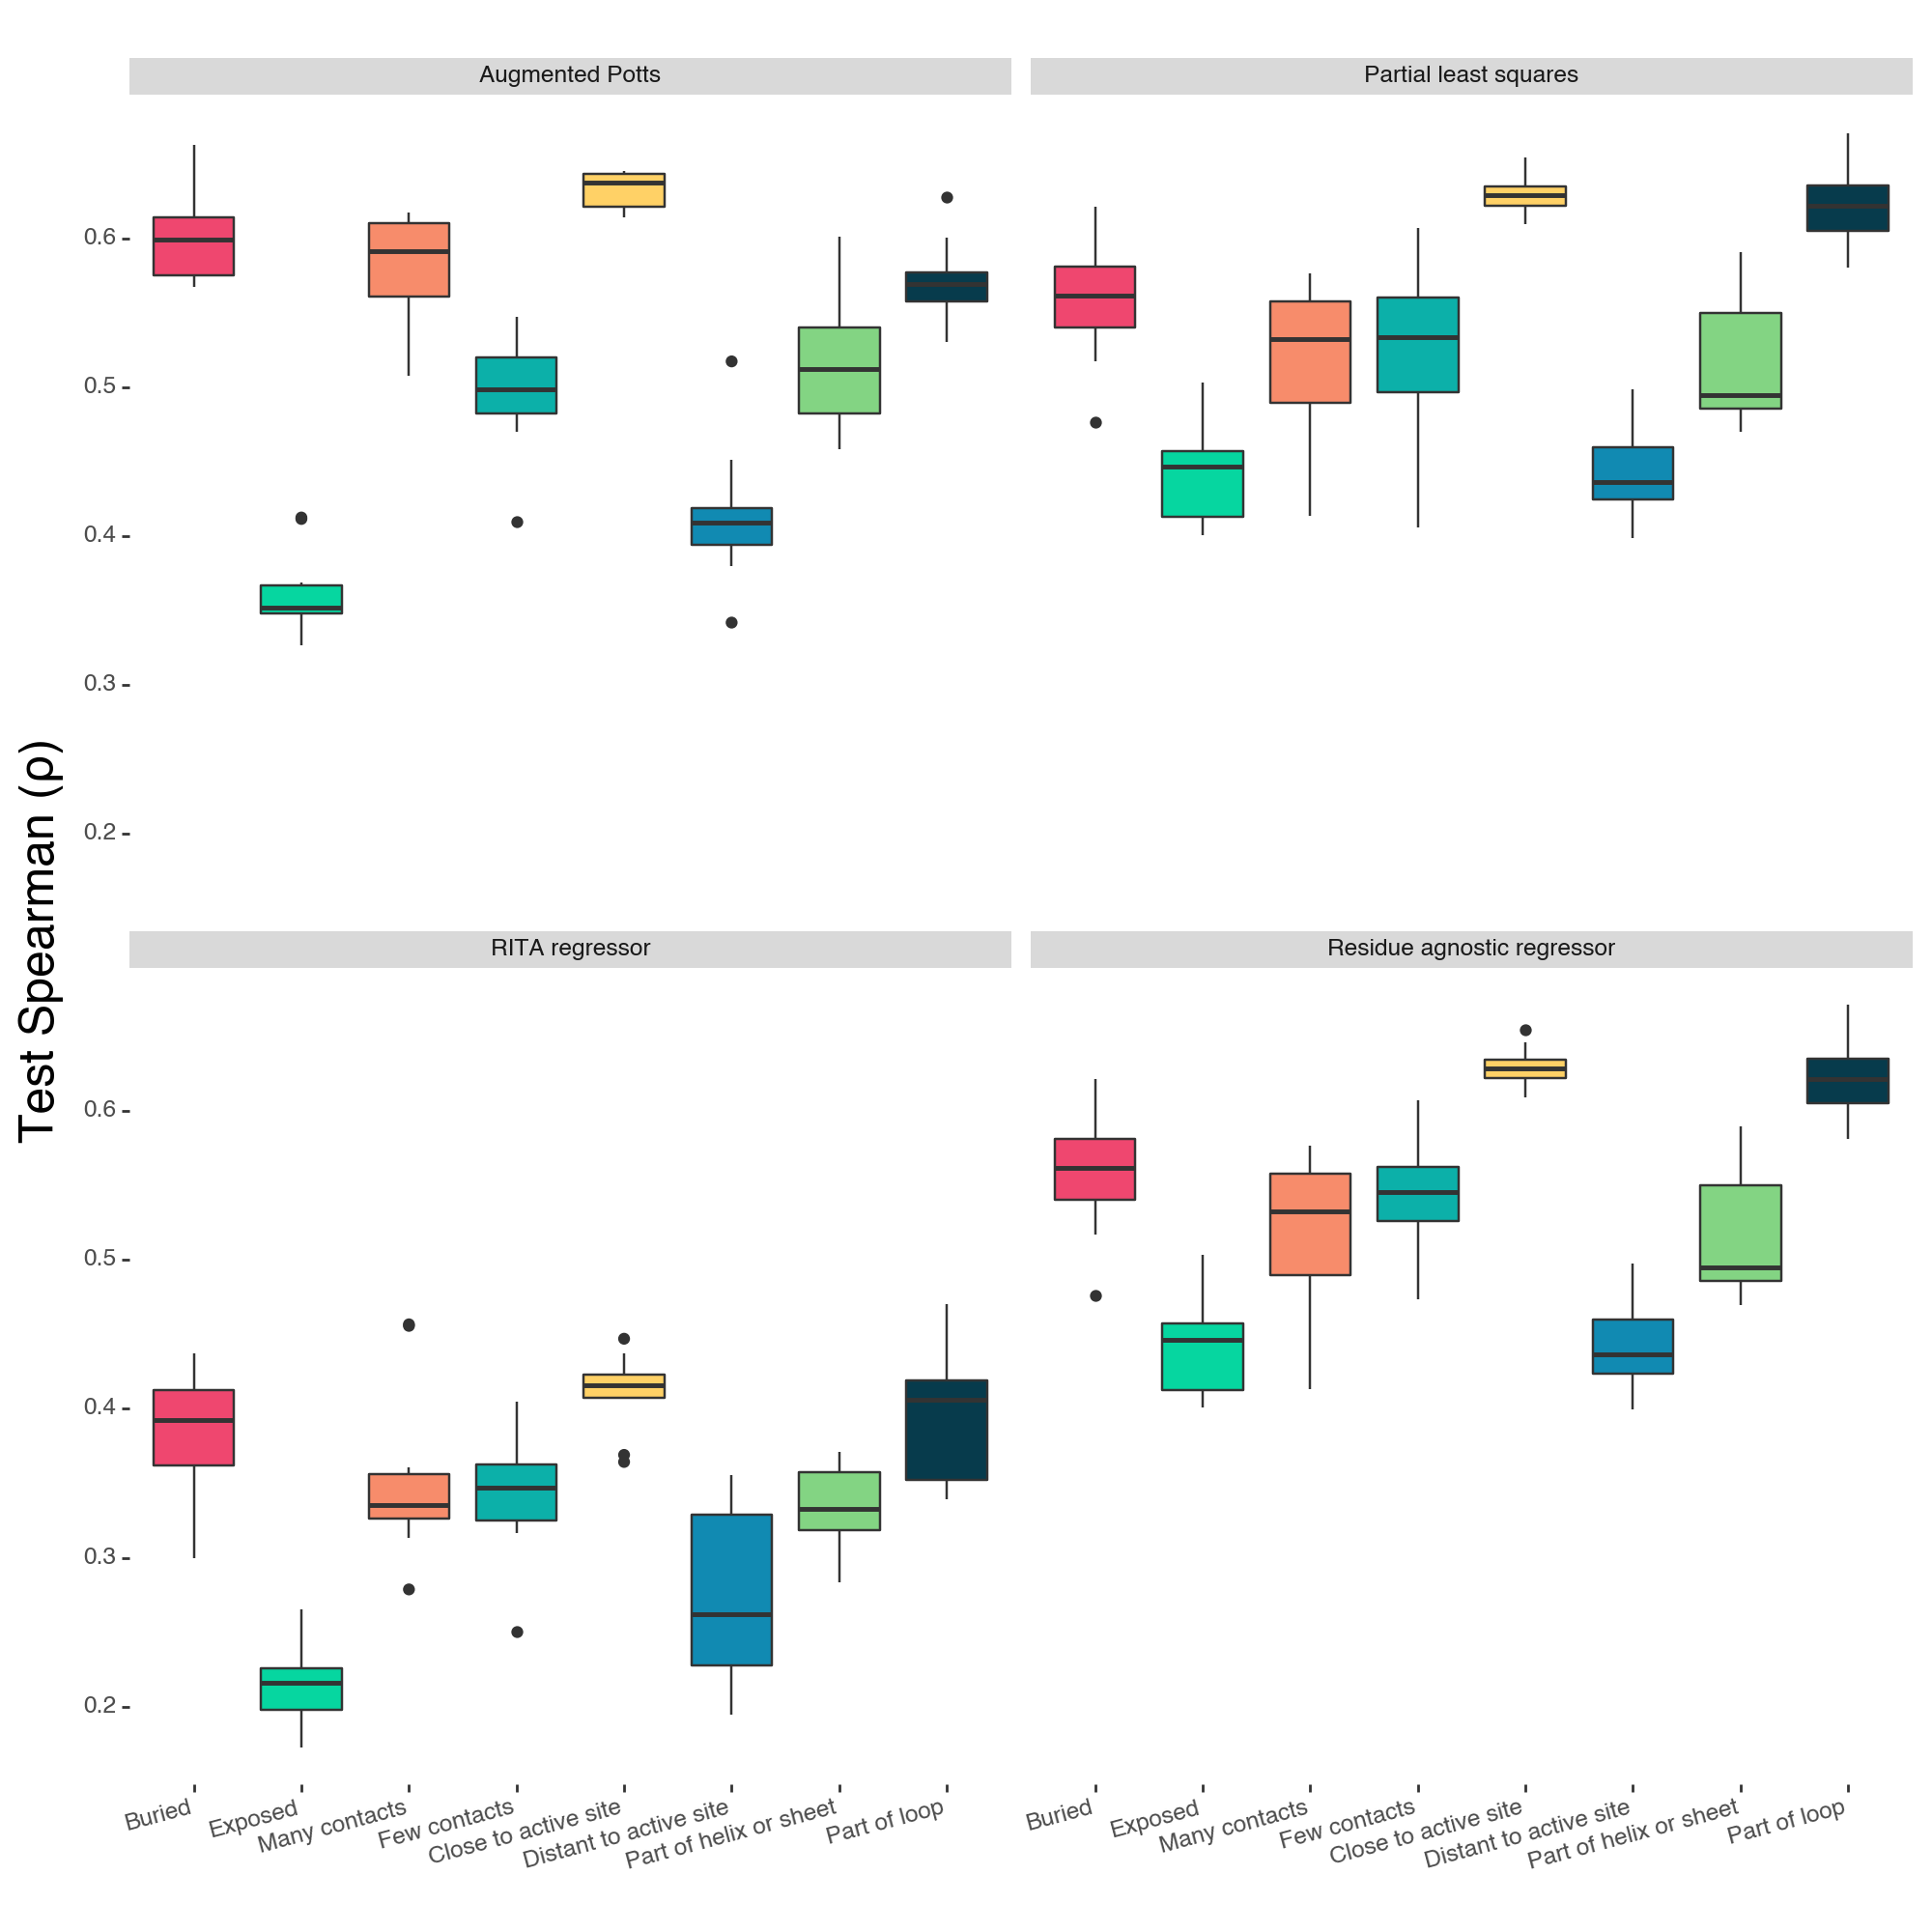

In [8]:
import plotnine as p9
from predictability.plotting import feature_mapping, color_mapping, assign_pretty_feature_names

results_df["is_member"] = results_df["is_member"].astype(bool)
results_df["Feature label"] = results_df["is_member"].apply(lambda x: "Negative" if x==False else "Positive")
results_df["Feature"] = results_df["structural_characteristic"].apply(assign_pretty_feature_names)

results_df["Structural characteristic"] = results_df[['Feature', 'Feature label']].apply(
    lambda x: feature_mapping[tuple(x)], axis=1
)
results_df["Structural characteristic"] = pd.Categorical(results_df["Structural characteristic"],
                                                     categories=["Buried", "Exposed", "Many contacts", "Few contacts",
                                                                 "Close to active site", "Distant to active site",
                                                                 "Part of helix or sheet", "Part of loop"],
                                                     ordered=True)

p = (
    p9.ggplot(
        results_df,
        p9.aes(
            "Structural characteristic",
            "spearman",
            fill="Structural characteristic",
        )
    )
    + p9.geom_boxplot(show_legend=False)
    + p9.facet_wrap("model", nrow=2, ncol=2)
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=15, ha="right"))
    + p9.scale_fill_manual(values=color_mapping)
    + p9.theme(
        plot_background=p9.element_rect(fill='white'),
        panel_background=p9.element_rect(fill='white'),
        axis_title_y=p9.element_text(text="Test Spearman (ρ)", size=18),
    )
    + p9.labs(x="")
)
p.draw()
# p.save(save_dir / "supervised_performance_difference.png")
print(p)

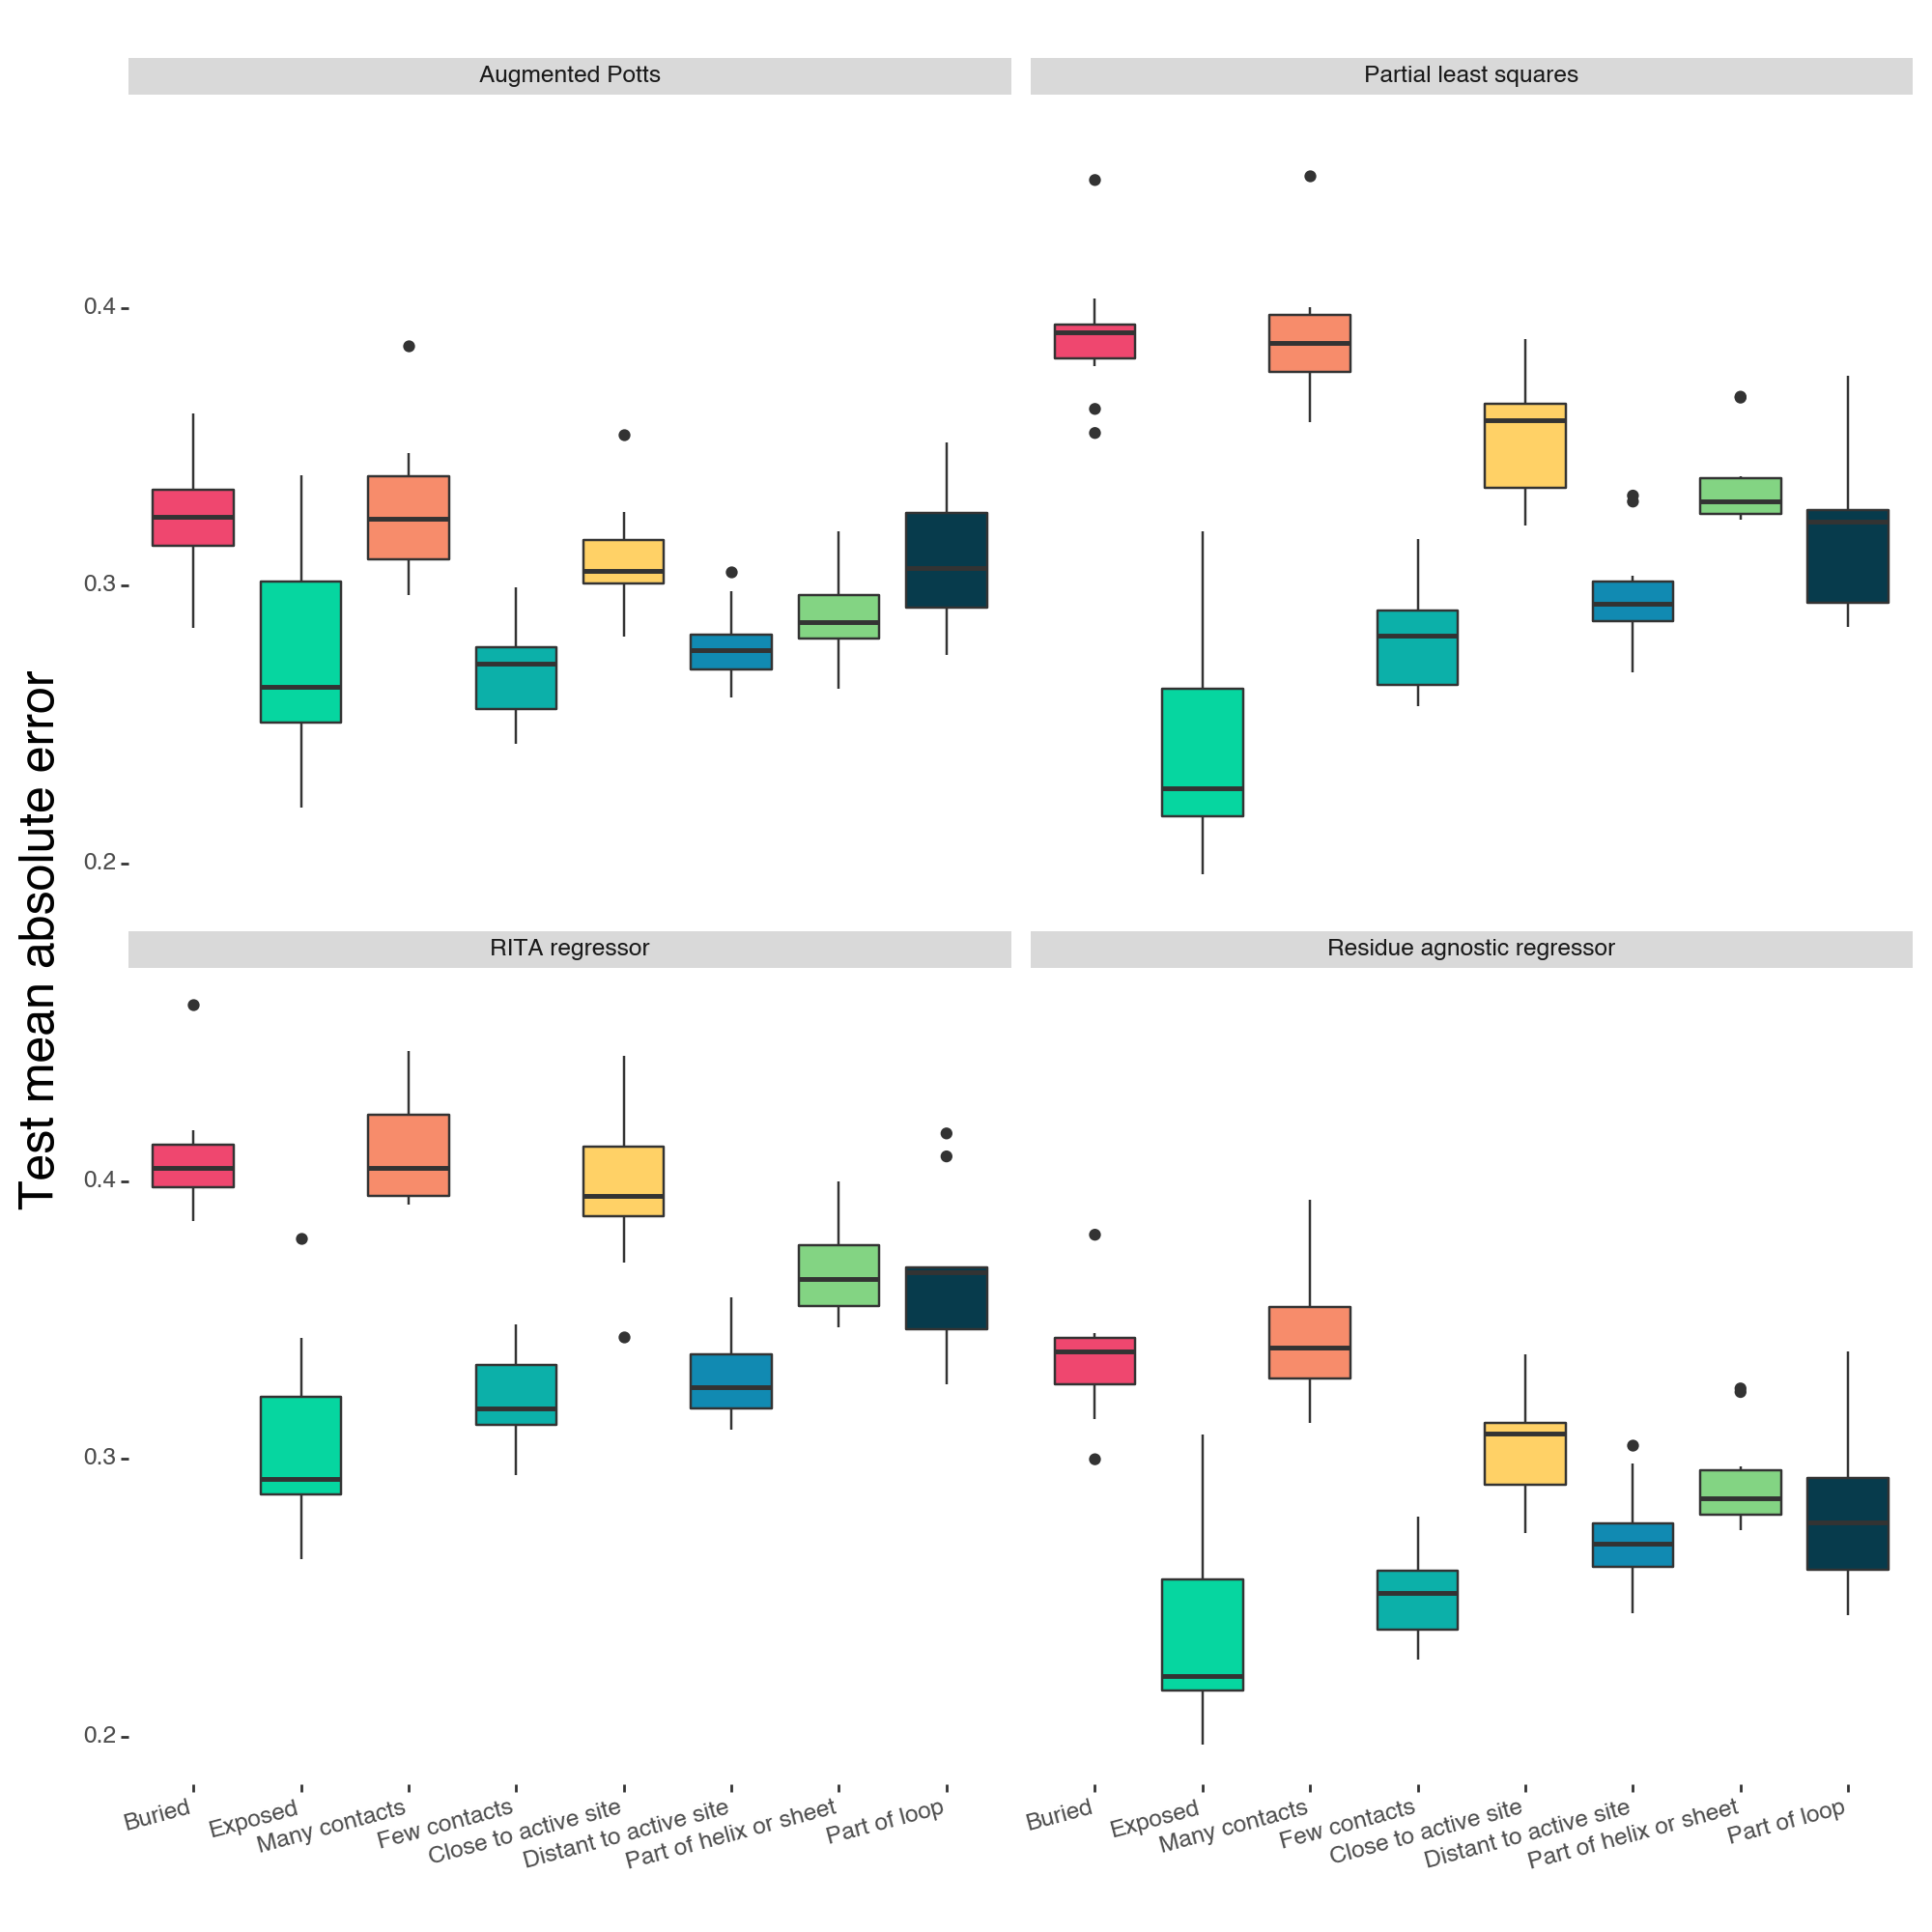

In [10]:
import plotnine as p9
from predictability.plotting import feature_mapping, color_mapping, assign_pretty_feature_names

results_df["is_member"] = results_df["is_member"].astype(bool)
results_df["Feature label"] = results_df["is_member"].apply(lambda x: "Negative" if x==False else "Positive")
results_df["Feature"] = results_df["structural_characteristic"].apply(assign_pretty_feature_names)

results_df["Structural characteristic"] = results_df[['Feature', 'Feature label']].apply(
    lambda x: feature_mapping[tuple(x)], axis=1
)
results_df["Structural characteristic"] = pd.Categorical(results_df["Structural characteristic"],
                                                     categories=["Buried", "Exposed", "Many contacts", "Few contacts",
                                                                 "Close to active site", "Distant to active site",
                                                                 "Part of helix or sheet", "Part of loop"],
                                                     ordered=True)

p = (
    p9.ggplot(
        results_df,
        p9.aes(
            "Structural characteristic",
            "mae",
            fill="Structural characteristic",
        )
    )
    + p9.geom_boxplot(show_legend=False)
    + p9.facet_wrap("model", nrow=2, ncol=2)
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=15, ha="right"))
    + p9.scale_fill_manual(values=color_mapping)
    + p9.theme(
        plot_background=p9.element_rect(fill='white'),
        panel_background=p9.element_rect(fill='white'),
        axis_title_y=p9.element_text(text="Test mean absolute error", size=18),
    )
    + p9.labs(x="")
)
p.draw()
# p.save(save_dir / "supervised_performance_difference.png")
print(p)